In [ ]:
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.tokenize import word_tokenize
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import nltk
import optuna
from sklearn.model_selection import train_test_split
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.stem.snowball import SnowballStemmer
import xgboost as xgb

In [ ]:
data = pd.read_json('News_Category_Dataset_v3.json', lines=True)
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
data = data.drop(columns=['authors','link','date'])
data.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [ ]:
data['content'] = data.headline + ' ' + data.short_description
labels = data.category
data.head()

,headline,category,short_description,content
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...


In [ ]:
text = pd.DataFrame(data.content)
labels = data.category

In [ ]:
train, test, train_labels, test_labels = train_test_split(text, labels,
random_state=42,test_size=0.20, stratify=labels)

In [ ]:
def normalise_text(text):
    text = text.lower()  # lowercase
    text = text.replace(r"\#", "")  # replaces hashtags
    text = text.replace(r"http\S+", "URL")  # remove URL addresses
    text = text.replace(r"@", "")
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    return text

def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", " ", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    # text = [word for word in text.split()]
    
    # word lemmatization
    # sentence = []
    # snow_stemmer = SnowballStemmer(language='english')
    # lemmatizer = WordNetLemmatizer()
    # for word in text:
        # sentence.append(snow_stemmer.stem(word))
        # sentence.append(lemmatizer.lemmatize(word,'v'))
        # sentence.append(lemmatizer.lemmatize(word))
        
    return ' '.join(text) 

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# train.content = train.content.apply(normalise_text)
# test.content = test.content.apply(normalise_text)

train.content = train.content.apply(datacleaning)
test.content = test.content.apply(datacleaning)

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 4),
                        stop_words='english',
                        tokenizer=word_tokenize)
train_tfidf = tfidf.fit_transform(train.content)
test_tfidf = tfidf.transform(test.content)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
models = [
    # LogisticRegression(random_state=42, max_iter=10000),
    MultinomialNB(),
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=10000),
    SGDClassifier()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
i = 0
for model in models:
    model_name = str(model.__class__.__name__) + str(i)
    print(model_name)
    i += 1
    accuracies = cross_val_score(model, train_tfidf, train_labels, scoring='accuracy', cv=CV, verbose=3, n_jobs=3)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

MultinomialNB0


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:   12.2s remaining:   18.3s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   16.9s finished


RandomForestClassifier1


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:   20.4s remaining:   30.6s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   32.4s finished


LinearSVC2


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  4.3min finished


SGDClassifier3


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:   54.6s remaining:  1.4min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  1.5min finished


In [ ]:
models = [
    LGBMClassifier(),
    xgb.XGBClassifier()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
i = 0
for model in models:
    model_name = str(model.__class__.__name__) + str(i)
    print(model_name)
    i += 1
    accuracies = cross_val_score(model, train_tfidf, train_labels, scoring='accuracy', cv=CV, verbose=3, n_jobs=3)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

LGBMClassifier0


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed: 26.6min remaining: 39.9min


KeyboardInterrupt: ignored

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC2,0.625214,0.002223
MultinomialNB0,0.378676,0.000802
RandomForestClassifier1,0.174984,0.000387
SGDClassifier3,0.584503,0.002009


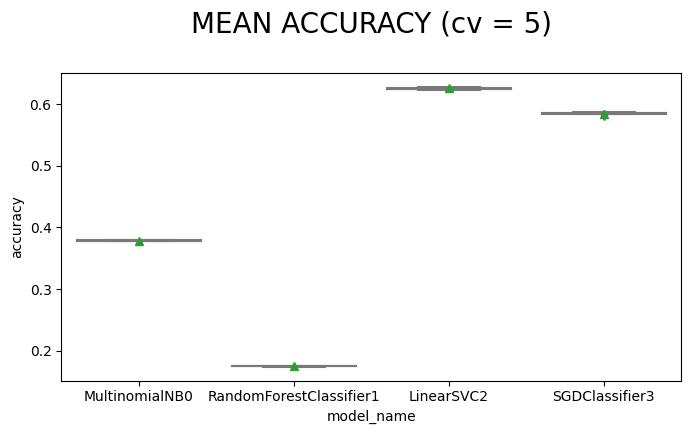

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

1. text_normalize

In [ ]:
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.5
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6232997661432731
F1 Score (Micro) = 0.6232997661432731
F1 Score (Macro) = 0.51823951477578
F1 Score (Weighted) = 0.6254381439436786


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.31      0.35      0.33       302
ARTS & CULTURE       0.36      0.40      0.38       268
  BLACK VOICES       0.51      0.51      0.51       917
      BUSINESS       0.54      0.50      0.52      1198
       COLLEGE       0.39      0.53      0.45       229
        COMEDY       0.58      0.51      0.54      1080
         CRIME       0.50      0.63      0.55       712
CULTURE & ARTS       0.44      0.38      0.40       215
       DIVORCE       0.75      0.76      0.76       685
     EDUCATION       0.34      0.52      0.41       203
 ENTERTAINMENT       0.75      0.67      0.71      3473
   ENVIRONMENT       0.46      0.40      0.43       289
         FIFTY       0.30      0.37      0.33       280
  FOOD & DRINK       0.65      0.70      0.67      1268
     GOOD NEWS       0.27      0.34      0.30       280
         GREEN       0.36      0.40      0.38       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX\n')

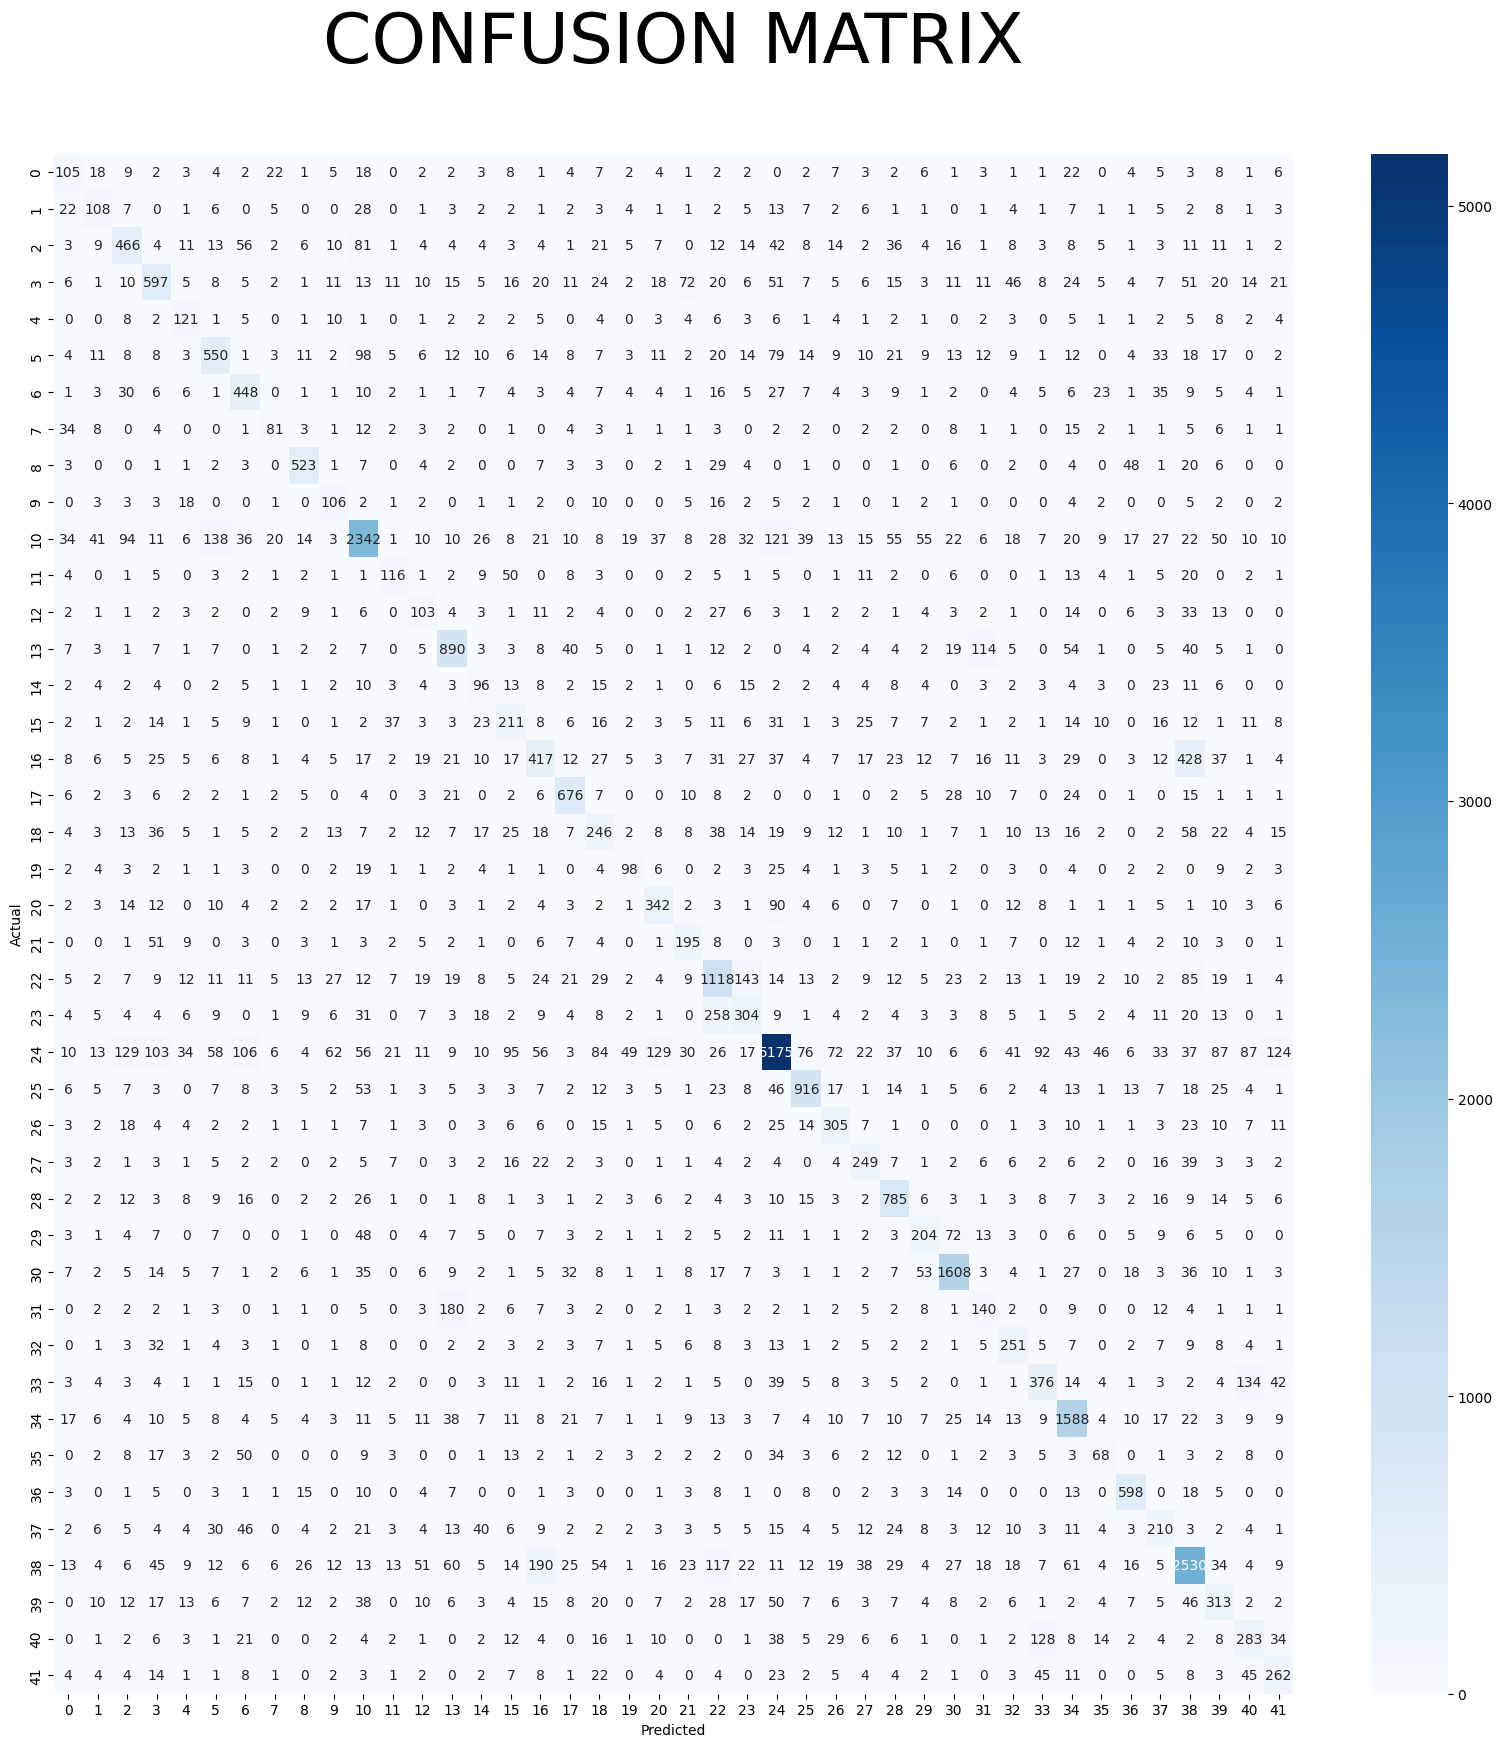

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=50)

2.Токенизация + стоп-слова + лемматизация

In [ ]:
clf = LinearSVC(C=0.4, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.4
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.5955471770152245
F1 Score (Micro) = 0.5955471770152245
F1 Score (Macro) = 0.4905444272753518
F1 Score (Weighted) = 0.6020835649300591


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.24      0.33      0.28       302
ARTS & CULTURE       0.25      0.33      0.28       268
  BLACK VOICES       0.49      0.51      0.50       917
      BUSINESS       0.54      0.48      0.51      1198
       COLLEGE       0.34      0.56      0.42       229
        COMEDY       0.57      0.49      0.53      1080
         CRIME       0.47      0.65      0.55       712
CULTURE & ARTS       0.38      0.35      0.37       215
       DIVORCE       0.76      0.76      0.76       685
     EDUCATION       0.30      0.57      0.39       203
 ENTERTAINMENT       0.76      0.63      0.69      3473
   ENVIRONMENT       0.33      0.37      0.35       289
         FIFTY       0.22      0.33      0.27       280
  FOOD & DRINK       0.63      0.68      0.65      1268
     GOOD NEWS       0.25      0.36      0.30       280
         GREEN       0.34      0.44      0.38       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX\n')

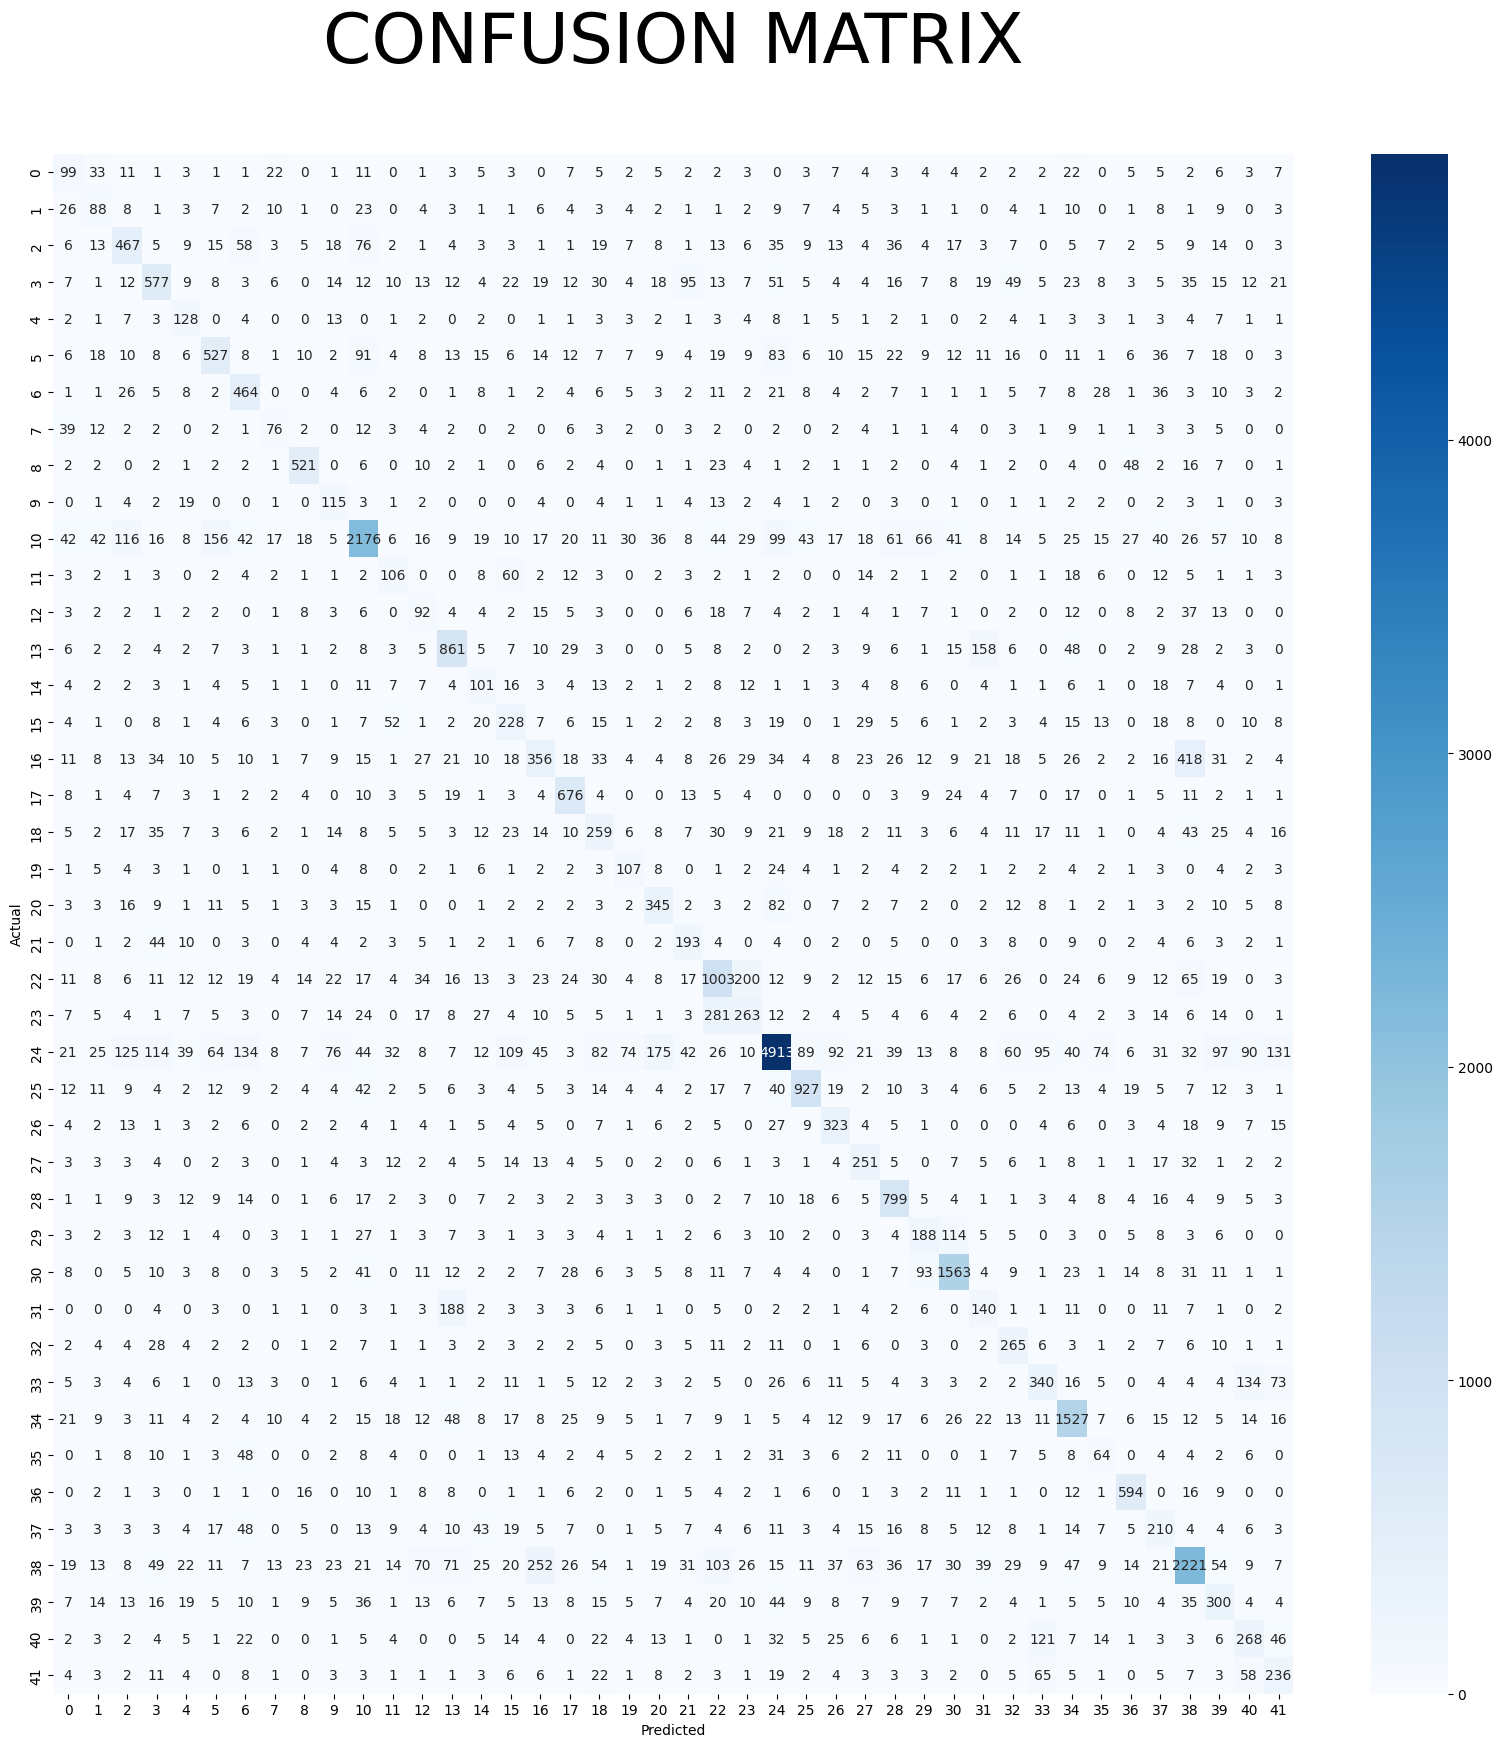

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=50)

3. Токенизация + стоп-слова + стемминг

In [ ]:
clf = LinearSVC(C=0.35, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.35
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.5961914761609316
F1 Score (Micro) = 0.5961914761609316
F1 Score (Macro) = 0.49223755349605886
F1 Score (Weighted) = 0.6028143544908217


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.25      0.34      0.29       302
ARTS & CULTURE       0.25      0.33      0.28       268
  BLACK VOICES       0.49      0.51      0.50       917
      BUSINESS       0.54      0.48      0.51      1198
       COLLEGE       0.34      0.56      0.42       229
        COMEDY       0.57      0.49      0.53      1080
         CRIME       0.47      0.66      0.55       712
CULTURE & ARTS       0.39      0.36      0.38       215
       DIVORCE       0.76      0.76      0.76       685
     EDUCATION       0.30      0.58      0.39       203
 ENTERTAINMENT       0.77      0.63      0.69      3473
   ENVIRONMENT       0.33      0.38      0.36       289
         FIFTY       0.22      0.34      0.27       280
  FOOD & DRINK       0.63      0.68      0.66      1268
     GOOD NEWS       0.25      0.36      0.30       280
         GREEN       0.35      0.44      0.39       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX\n')

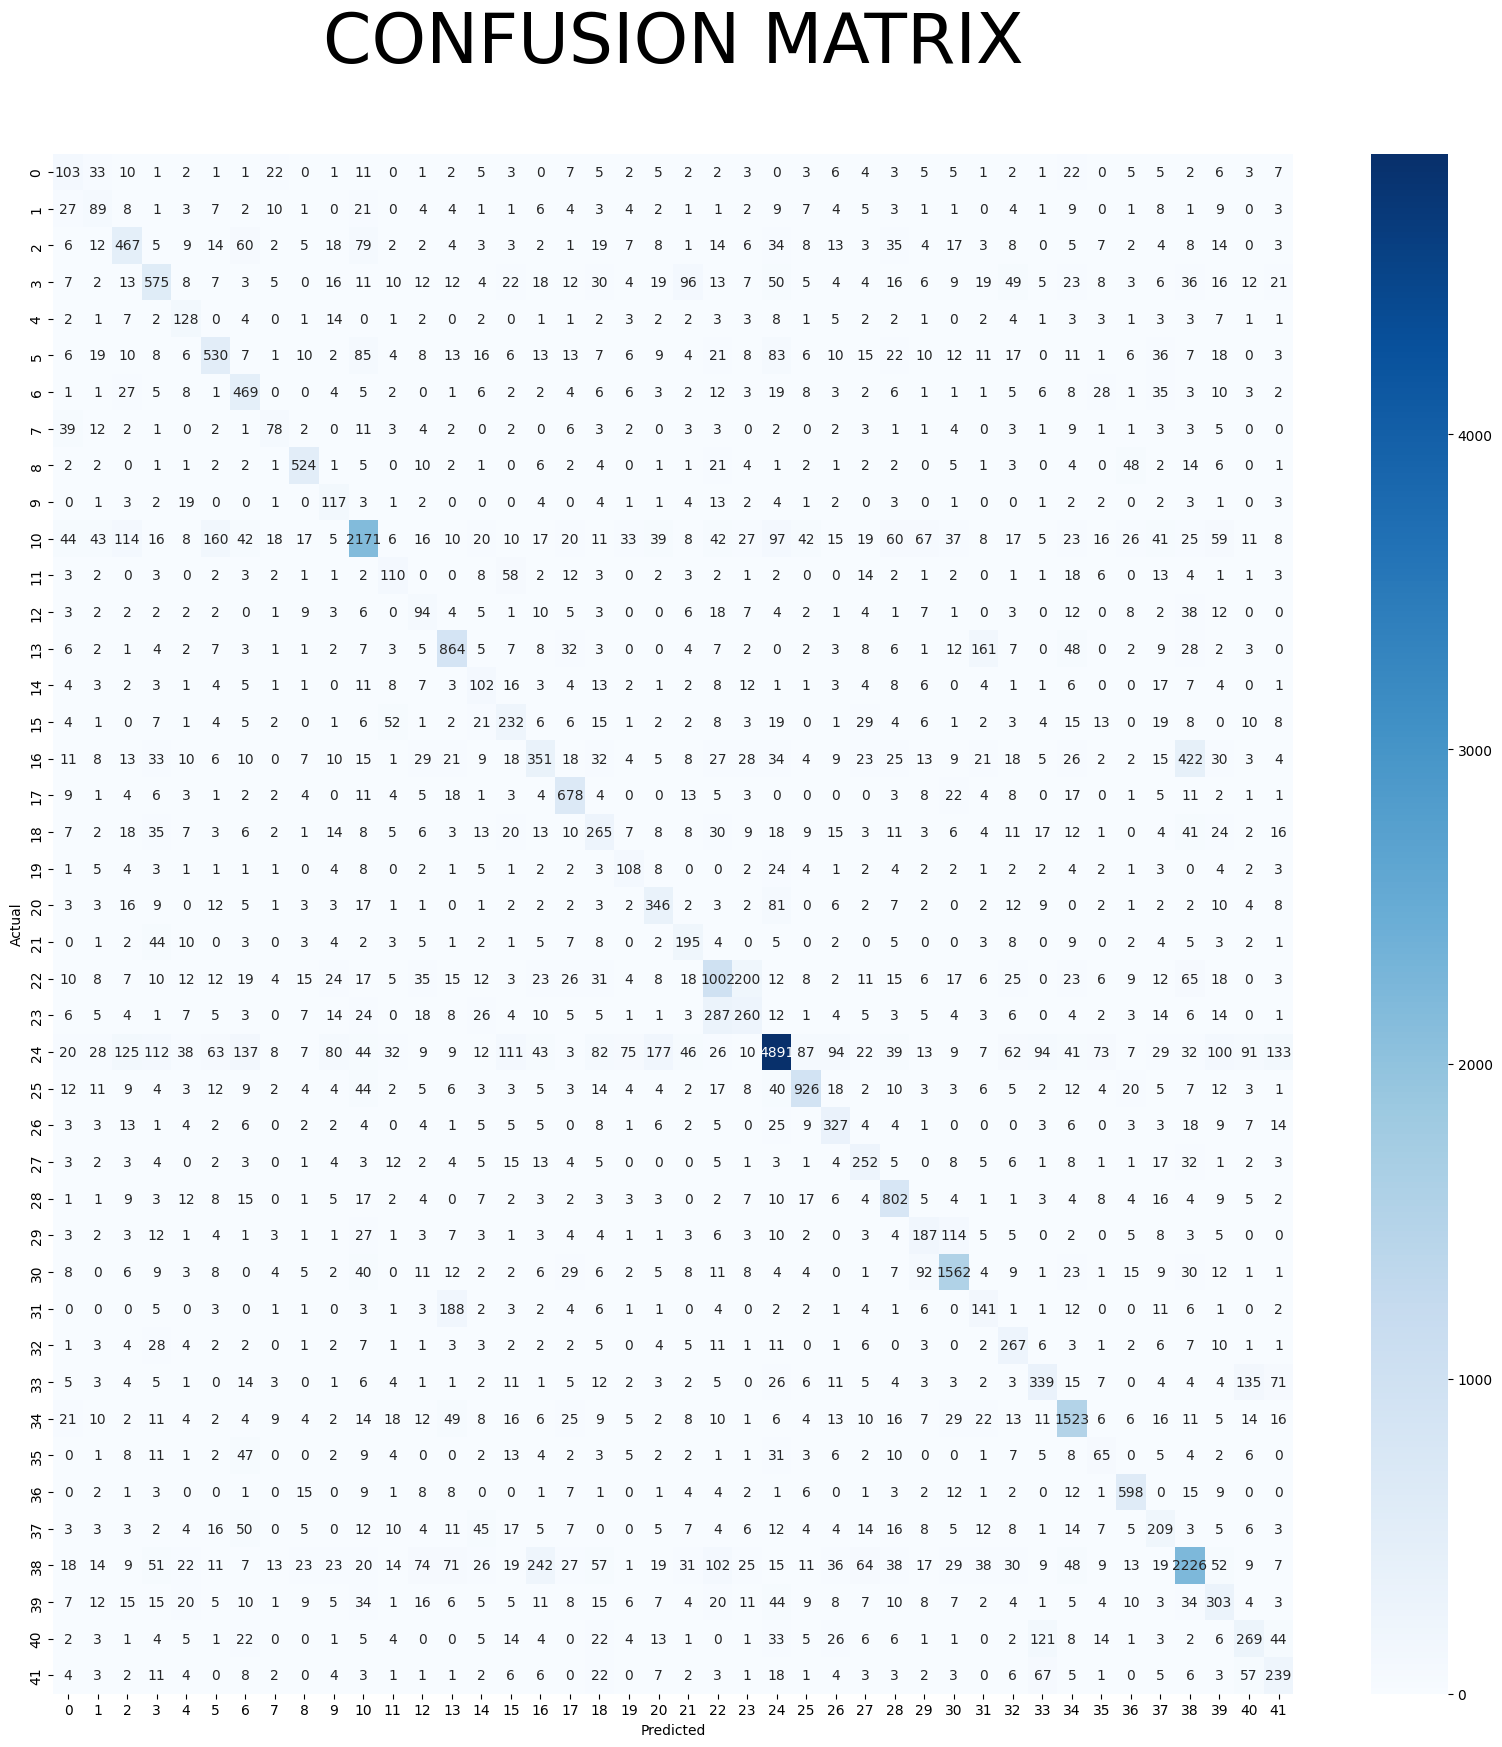

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=50)

4. Токенизация + лемматизация

In [ ]:
clf = LinearSVC(C=0.44, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.44
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6079320383715936
F1 Score (Micro) = 0.6079320383715936
F1 Score (Macro) = 0.5008776152207028
F1 Score (Weighted) = 0.6109124211762899


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.26      0.29      0.27       302
ARTS & CULTURE       0.30      0.34      0.32       268
  BLACK VOICES       0.50      0.51      0.50       917
      BUSINESS       0.51      0.49      0.50      1198
       COLLEGE       0.40      0.55      0.46       229
        COMEDY       0.56      0.49      0.53      1080
         CRIME       0.49      0.65      0.56       712
CULTURE & ARTS       0.38      0.34      0.36       215
       DIVORCE       0.74      0.76      0.75       685
     EDUCATION       0.32      0.53      0.40       203
 ENTERTAINMENT       0.76      0.64      0.69      3473
   ENVIRONMENT       0.40      0.38      0.39       289
         FIFTY       0.28      0.34      0.31       280
  FOOD & DRINK       0.64      0.71      0.67      1268
     GOOD NEWS       0.25      0.34      0.29       280
         GREEN       0.36      0.42      0.39       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX\n')

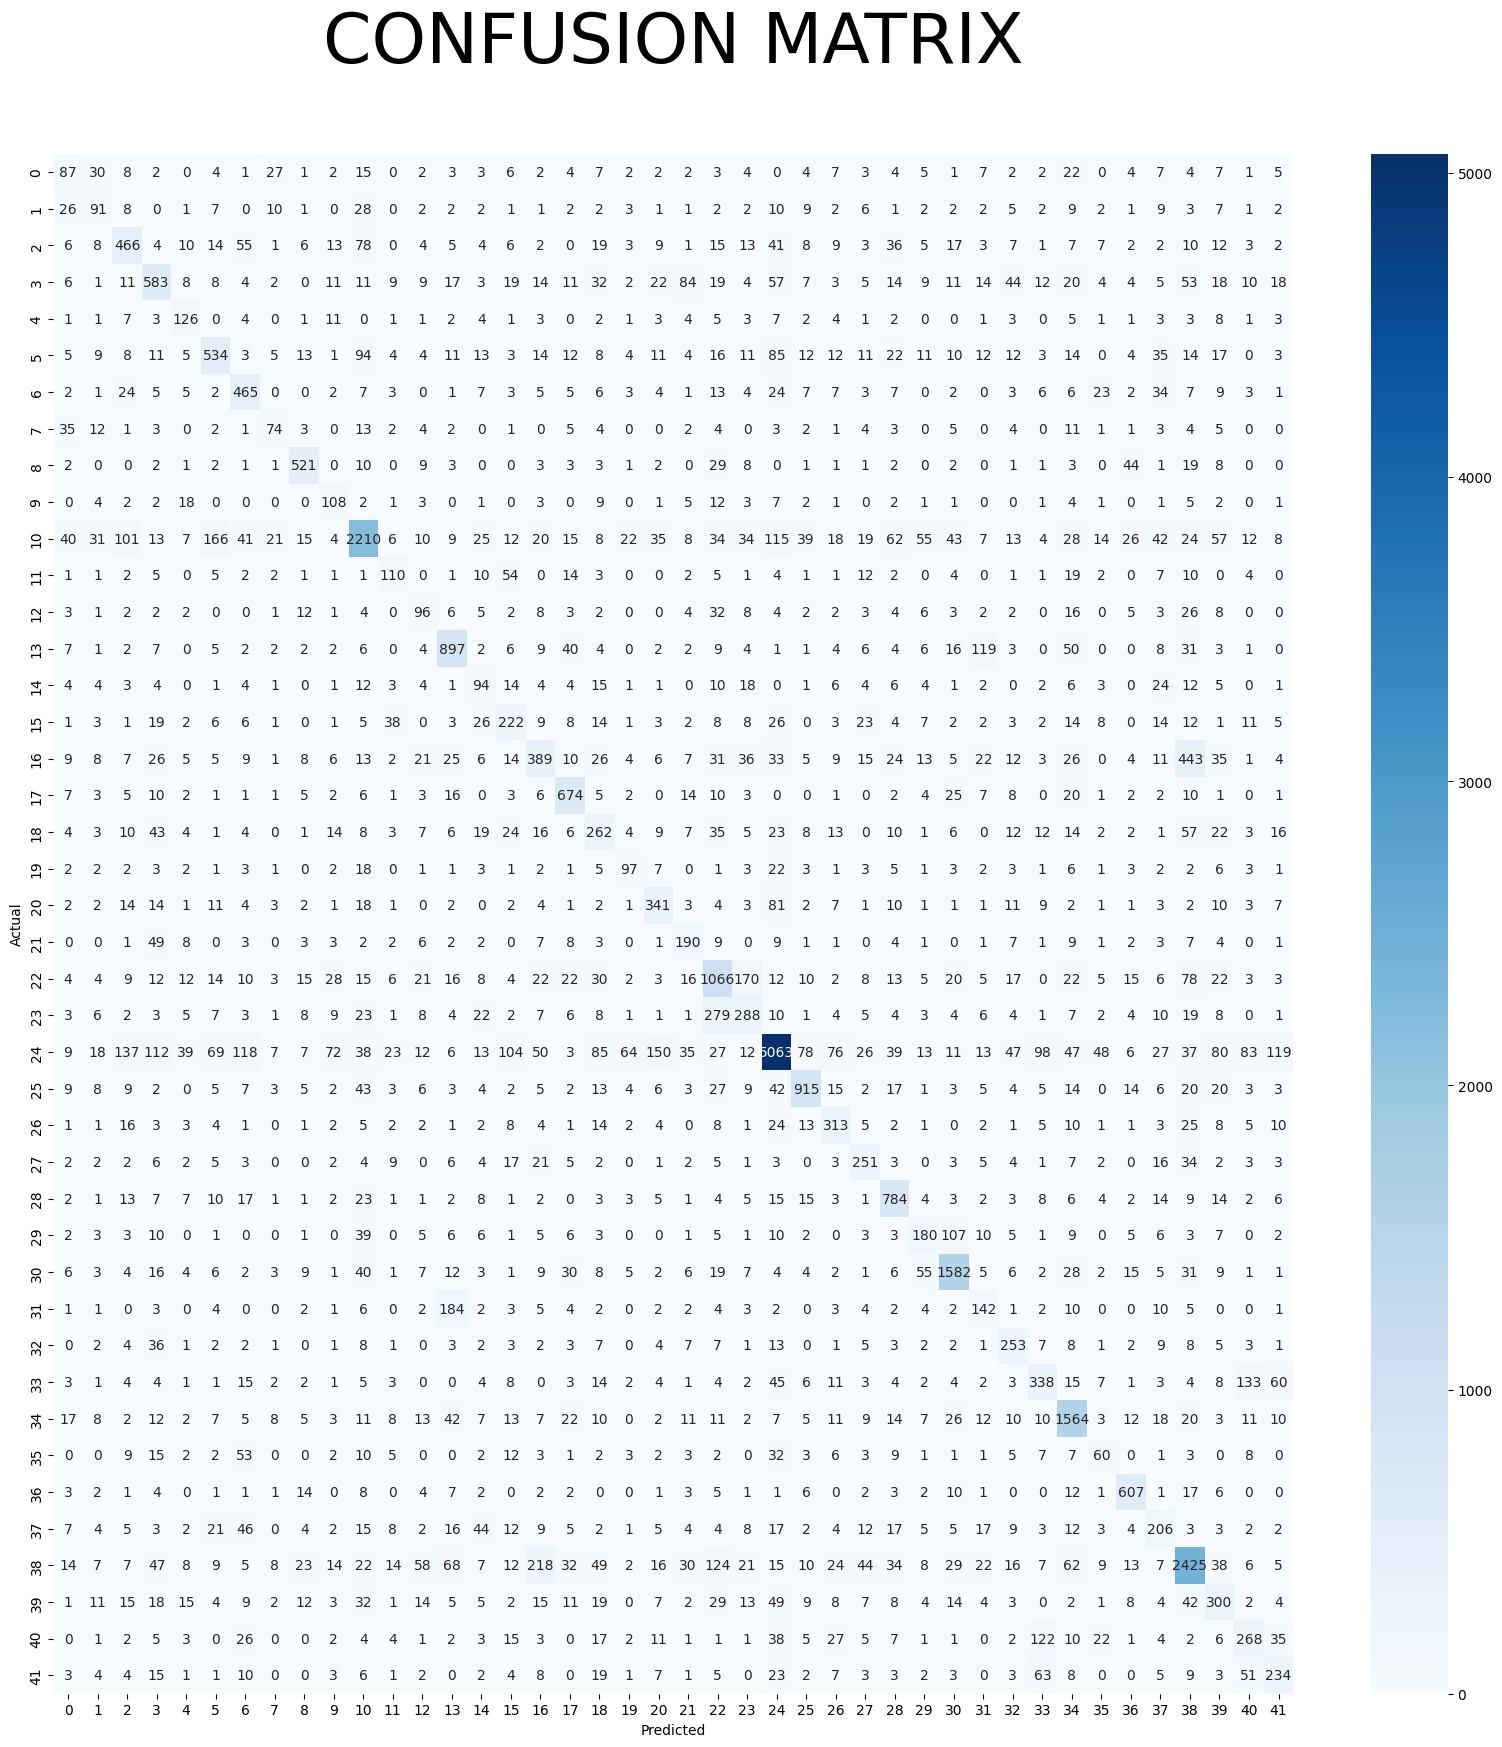

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=50)

5. Токенизация + стемминг

In [ ]:
clf = LinearSVC(C=0.43, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.43
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6078604495776261
F1 Score (Micro) = 0.6078604495776261
F1 Score (Macro) = 0.5009391107112681
F1 Score (Weighted) = 0.6108493577785824


In [ ]:
clf = LinearSVC(C=0.44, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.44
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6079320383715936
F1 Score (Micro) = 0.6079320383715936
F1 Score (Macro) = 0.5008776152207028
F1 Score (Weighted) = 0.6109124211762899


In [ ]:
clf = LinearSVC(C=0.42, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.42
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6076934090583688
F1 Score (Micro) = 0.6076934090583688
F1 Score (Macro) = 0.5009244007006624
F1 Score (Weighted) = 0.6107379962260988


6. Токенизация + Стоп-слова

In [ ]:
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.5
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

In [ ]:
clf = LinearSVC(C=0.1, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.1
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

In [ ]:
clf = LinearSVC(C=1, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_tfidf, train_labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 1
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")